In [1]:
from fastai.vision import *
import pydicom
%config IPCompleter.greedy=True

In [2]:
images_root_path = Path("data/siim/dicom-images-train")
files = images_root_path.glob('**/*.dcm')
input_images = [path.relative_to(images_root_path) for path in files]

file_map = {path.stem : path for path in input_images}

In [3]:
def remap(value):
    if value == "-1":
        return "no"
    else:
        return "yes"

df = pd.read_csv('data/siim/train-rle.csv', header='infer')
df["present"] = df[" EncodedPixels"].map(remap)
df["ImageId"] = df["ImageId"].map(lambda filename: file_map[filename])
df.head()

,ImageId,EncodedPixels,present
0,1.2.276.0.7230010.3.1.2.8323329.6904.151787520...,-1,no
1,1.2.276.0.7230010.3.1.2.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,yes
2,1.2.276.0.7230010.3.1.2.8323329.11028.15178752...,-1,no
3,1.2.276.0.7230010.3.1.2.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,yes
4,1.2.276.0.7230010.3.1.2.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,yes


In [4]:
def dcm_to_image(dcm_path, **kwargs):
    pixel_data = pydicom.dcmread(dcm_path).pixel_array
    image = PIL.Image.fromarray(pixel_data).convert('RGB')
    return Image(pil2tensor(image, np.float32).div_(255))

vision.data.open_image = dcm_to_image

In [5]:
def rle2mask(rle, width, height):
    mask= np.zeros(width* height,dtype=np.uint)
    if rle == '-1':
        return mask.reshape(width, height)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 1
        current_position += lengths[index]

    return mask.reshape(width, height)

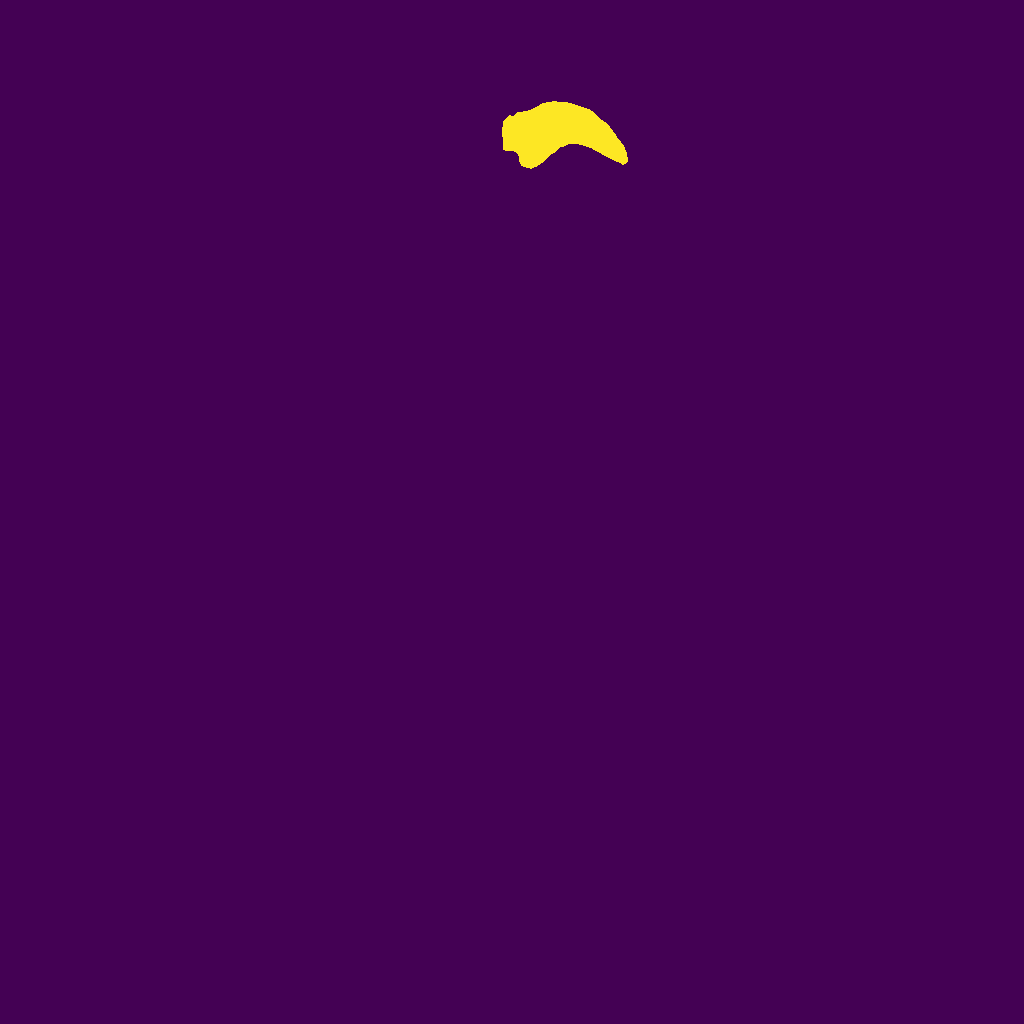

In [6]:
def siim_open_mask_rle(mask_rle:str, shape:Tuple[int, int])->ImageSegment:
    "Return `ImageSegment` object create from run-length encoded string in `mask_lre` with size in `shape`."
    x = FloatTensor(rle2mask(str(mask_rle), shape[0], shape[1]).astype(np.uint8))
    x = x.view(shape[1], shape[0], -1)
    return ImageSegment(x.permute(2,1,0))

siim_open_mask_rle(df.iloc[3][' EncodedPixels'], shape=(1024,1024))

In [7]:
classes=['no','yes']

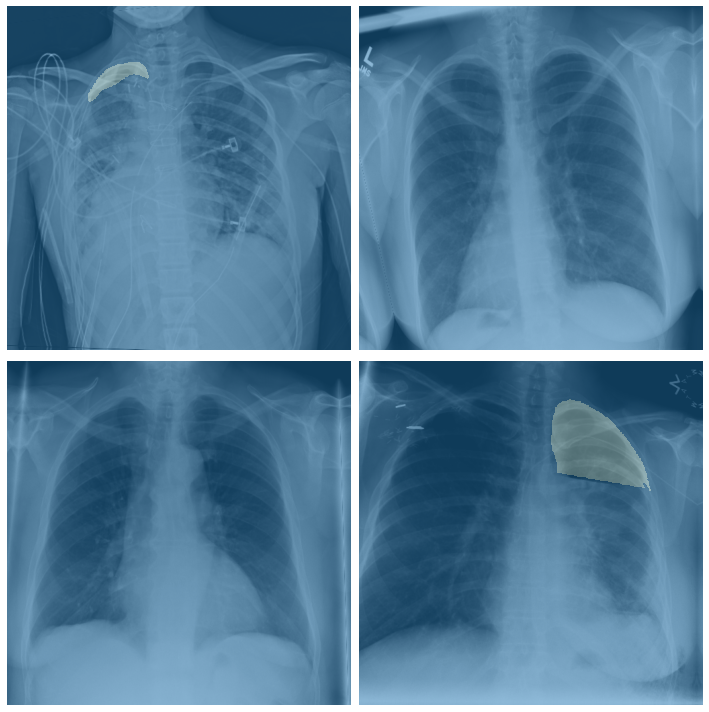

In [8]:
vision.data.open_mask = lambda fn, **kwargs: siim_open_mask_rle(fn, shape=(1024,1024))

src = SegmentationItemList.from_df(df, Path('data/siim/dicom-images-train')).split_by_rand_pct().label_from_df(classes=classes)
data = (src.transform(get_transforms(), size=512, tfm_y=True)
        .databunch(bs=8)
        .normalize(imagenet_stats))
data.show_batch(2, figsize=(10,10))

In [9]:
name2id = {v:k for k,v in enumerate(classes)}

def acc_camvid(input, target):
    print(input)
    print(target)
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)==target).float().mean()

metrics=acc_camvid
wd=1e-2

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
lr_find(learn)
learn.recorder.plot()